### Import

In [1]:
import tensorflow
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import TopKCategoricalAccuracy

from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

import numpy as np



print(tensorflow.config.list_physical_devices())


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

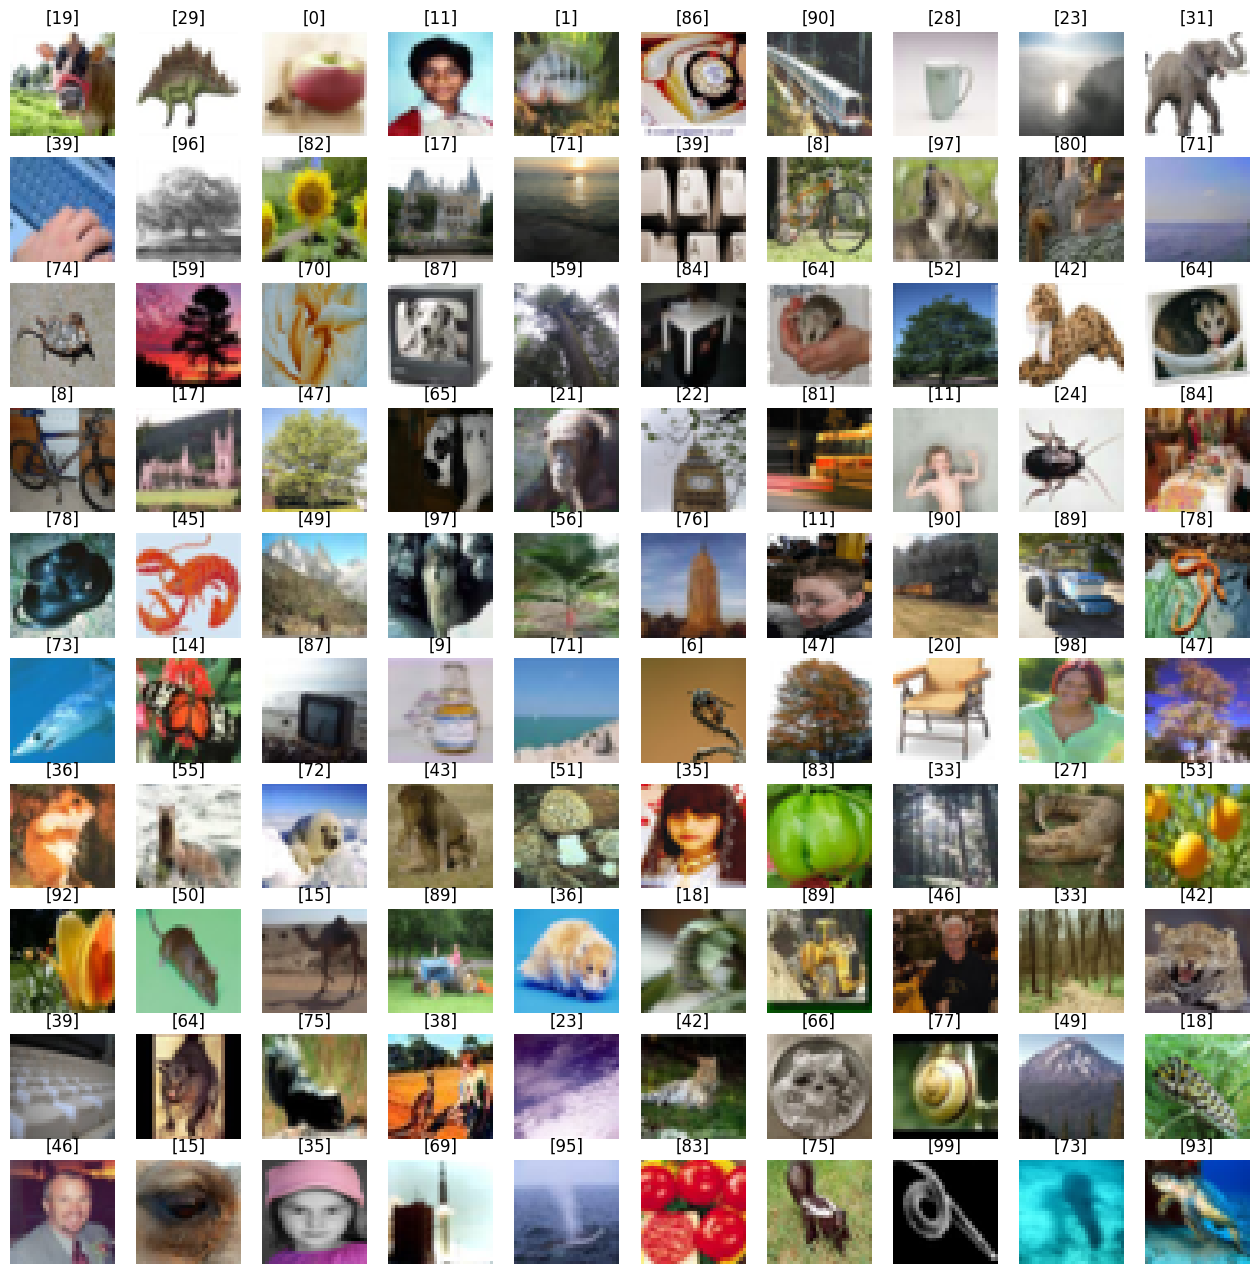

In [3]:
plt.figure(figsize=(16, 16))
for i in range(100):
    ax = plt.subplot(10, 10, i+1)
    plt.imshow(np.array(x_train[i]))
    plt.title(str(y_train[i]))
    plt.axis("off")

In [4]:
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


Нормалізація

In [5]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [6]:
x_train[0]

array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.7647059 , 0.8039216 , 0.75686276],
        [0.83137256, 0.8784314 , 0.8       ],
        [0.7137255 , 0.7607843 , 0.654902  ]],

       [[1.        , 1.        , 1.        ],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        ...,
        [0.6666667 , 0.6901961 , 0.5882353 ],
        [0.6313726 , 0.65882355, 0.50980395],
        [0.57254905, 0.6039216 , 0.44313726]],

       [[1.        , 1.        , 1.        ],
        [0.99607843, 0.99607843, 0.99607843],
        [1.        , 1.        , 1.        ],
        ...,
        [0.7411765 , 0.78039217, 0.6627451 ],
        [0.6509804 , 0.69803923, 0.50980395],
        [0.4745098 , 0.52156866, 0.34117648]],

       ...,

       [[0.5803922 , 0.7254902 , 0.30980393],
        [0.5568628 , 0.7137255 , 0.22352941],
        [0.54901963, 0

Категоріальні дані

In [7]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [8]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

Валідаційні дані

In [9]:
x_valid = x_train[40_000:]
y_valid = y_train[40_000:]

x_train = x_train[:40_000]
y_train = y_train[:40_000]

In [10]:
print(x_valid.shape)
print(y_valid.shape)

(10000, 32, 32, 3)
(10000, 100)


In [11]:
print(x_train.shape)
print(y_train.shape)

(40000, 32, 32, 3)
(40000, 100)


Тренування

### Baseline

In [12]:
model = Sequential([
    # Conv2D + BatchNorm + ReLU
    Conv2D(32, (3,3), padding='same', input_shape=(32,32,3)),
    BatchNormalization(),
    Activation('relu'),
    
    # Conv2D + BatchNorm + ReLU + MaxPooling + Dropout
    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    
    # Conv2D + BatchNorm + ReLU + MaxPooling + Dropout
    Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.4),
    
    # Dense Layers
    Flatten(),
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    
    Dense(100, activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 32, 32, 64)        0

In [13]:
model.compile(optimizer=Adam(learning_rate=.0001), 
               loss=CategoricalCrossentropy(),
               metrics=['accuracy', TopKCategoricalAccuracy(k=2, name="Top2")])

In [14]:
history = model.fit(x_train, y_train, batch_size=128, 
                     epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20
313/313 [==============================] - 7s 14ms/step - loss: 4.5335 - accuracy: 0.0589 - Top2: 0.0963 - val_loss: 4.7162 - val_accuracy: 0.0325 - val_Top2: 0.0608
Epoch 2/20
313/313 [==============================] - 4s 12ms/step - loss: 3.8901 - accuracy: 0.1219 - Top2: 0.1942 - val_loss: 3.5634 - val_accuracy: 0.1741 - val_Top2: 0.2616
Epoch 3/20
313/313 [==============================] - 4s 12ms/step - loss: 3.6235 - accuracy: 0.1590 - Top2: 0.2453 - val_loss: 3.2810 - val_accuracy: 0.2266 - val_Top2: 0.3278
Epoch 4/20
313/313 [==============================] - 4s 12ms/step - loss: 3.4372 - accuracy: 0.1903 - Top2: 0.2851 - val_loss: 3.1610 - val_accuracy: 0.2467 - val_Top2: 0.3535
Epoch 5/20
313/313 [==============================] - 4s 12ms/step - loss: 3.2978 - accuracy: 0.2105 - Top2: 0.3131 - val_loss: 3.0438 - val_accuracy: 0.2732 - val_Top2: 0.3830
Epoch 6/20
313/313 [==============================] - 4s 12ms/step - loss: 3.1737 - accuracy: 0.2350 - Top2: 0.3444

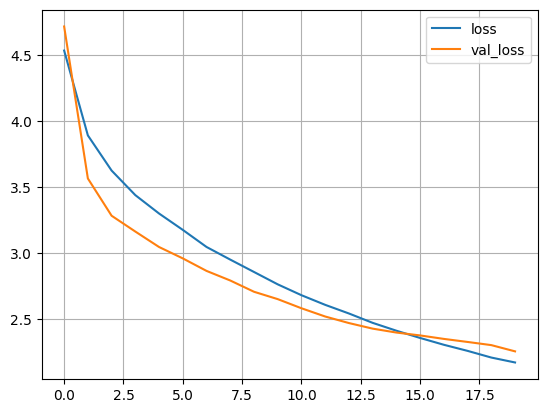

In [15]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
# plt.xticks(list(range(50)))
plt.grid()

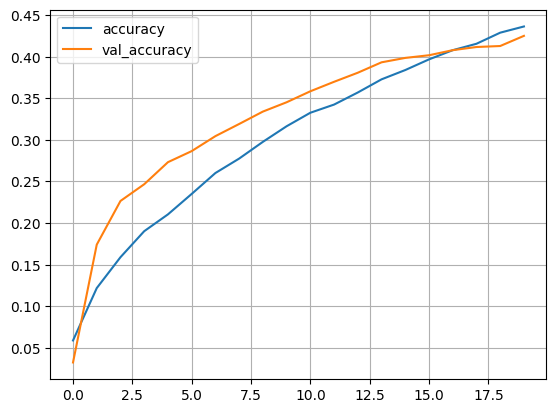

In [16]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.grid()

In [17]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 2.2284 - accuracy: 0.4241 - Top2: 0.5602


[2.228370189666748, 0.42410001158714294, 0.5601999759674072]

### Run#1

In [18]:
model_1 = Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation="relu", padding="same"),
    BatchNormalization(), 
    MaxPooling2D(2, 2),
    
    # Conv2D + BatchNorm + ReLU + MaxPooling + Dropout
    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    # Dropout(0.3),
    
    # Conv2D + BatchNorm + ReLU + MaxPooling + Dropout
    Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    # Dropout(0.4),
    
    # Conv2D + BatchNorm + ReLU + MaxPooling + Dropout
    Conv2D(256, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.4),
    
    # Dense Layers
    Flatten(),
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    
    Dense(100, activation='softmax'),
])

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                      

In [19]:
model_1.compile(optimizer=Adam(learning_rate=.0001), 
               loss=CategoricalCrossentropy(),
               metrics=['accuracy', TopKCategoricalAccuracy(k=2, name="Top2")])

In [20]:
history_1 = model_1.fit(x_train, y_train, batch_size=128, 
                     epochs=40, validation_data=(x_valid, y_valid))

Epoch 1/40
313/313 [==============================] - 3s 8ms/step - loss: 4.6774 - accuracy: 0.0418 - Top2: 0.0752 - val_loss: 4.6068 - val_accuracy: 0.0310 - val_Top2: 0.0530
Epoch 2/40
313/313 [==============================] - 2s 7ms/step - loss: 4.1323 - accuracy: 0.0855 - Top2: 0.1443 - val_loss: 3.7108 - val_accuracy: 0.1517 - val_Top2: 0.2331
Epoch 3/40
313/313 [==============================] - 2s 7ms/step - loss: 3.8781 - accuracy: 0.1157 - Top2: 0.1899 - val_loss: 3.4435 - val_accuracy: 0.1961 - val_Top2: 0.2934
Epoch 4/40
313/313 [==============================] - 2s 7ms/step - loss: 3.6945 - accuracy: 0.1402 - Top2: 0.2241 - val_loss: 3.3297 - val_accuracy: 0.2120 - val_Top2: 0.3120
Epoch 5/40
313/313 [==============================] - 2s 7ms/step - loss: 3.5498 - accuracy: 0.1640 - Top2: 0.2545 - val_loss: 3.1758 - val_accuracy: 0.2443 - val_Top2: 0.3514
Epoch 6/40
313/313 [==============================] - 2s 8ms/step - loss: 3.4192 - accuracy: 0.1833 - Top2: 0.2810 - val

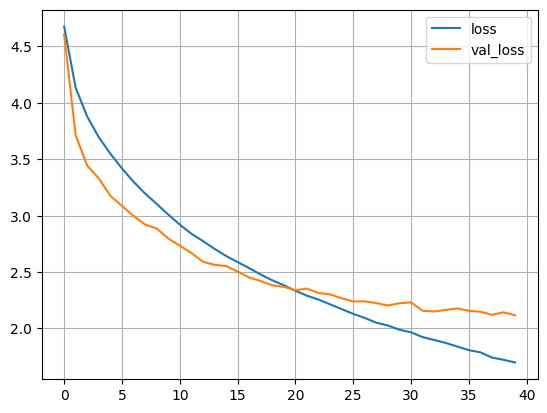

In [21]:
plt.plot(history_1.history["loss"], label="loss")
plt.plot(history_1.history["val_loss"], label="val_loss")
plt.legend()
plt.grid()

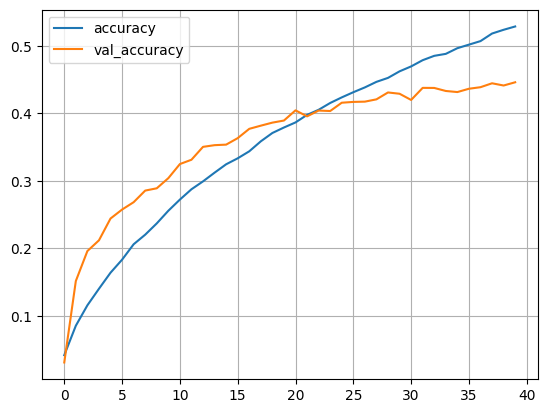

In [22]:
plt.plot(history_1.history["accuracy"], label="accuracy")
plt.plot(history_1.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.grid()

In [23]:
model_1.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 2.0778 - accuracy: 0.4545 - Top2: 0.5873


[2.077803134918213, 0.4544999897480011, 0.5873000025749207]

### Run#2

In [24]:
model_2 = Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(4, (3, 3), activation="relu", padding="same"),
    BatchNormalization(), 
    MaxPooling2D(2, 2),
    
    # Conv2D + BatchNorm + ReLU + MaxPooling + Dropout
    Conv2D(16, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    
    # Conv2D + BatchNorm + ReLU + MaxPooling + Dropout
    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.4),
    
    # Dense Layers
    Flatten(),
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    
    Dense(100, activation='softmax'),
])

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 32, 32, 4)         112       
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 4)        16        
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 4)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 16)        592       
                                                                 
 batch_normalization_10 (Bat  (None, 16, 16, 16)       64        
 chNormalization)                                                
                                                      

In [25]:
model_2.compile(optimizer=Adam(learning_rate=.0001), 
               loss=CategoricalCrossentropy(),
               metrics=['accuracy', TopKCategoricalAccuracy(k=2, name="Top2")])

In [26]:
history_2 = model_2.fit(x_train, y_train, batch_size=128, 
                     epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20
313/313 [==============================] - 3s 6ms/step - loss: 4.9549 - accuracy: 0.0209 - Top2: 0.0395 - val_loss: 4.6429 - val_accuracy: 0.0113 - val_Top2: 0.0230
Epoch 2/20
313/313 [==============================] - 1s 4ms/step - loss: 4.5641 - accuracy: 0.0391 - Top2: 0.0703 - val_loss: 4.2090 - val_accuracy: 0.0690 - val_Top2: 0.1129
Epoch 3/20
313/313 [==============================] - 1s 4ms/step - loss: 4.3920 - accuracy: 0.0503 - Top2: 0.0882 - val_loss: 4.0537 - val_accuracy: 0.0913 - val_Top2: 0.1489
Epoch 4/20
313/313 [==============================] - 1s 4ms/step - loss: 4.2685 - accuracy: 0.0589 - Top2: 0.1041 - val_loss: 3.9724 - val_accuracy: 0.1009 - val_Top2: 0.1678
Epoch 5/20
313/313 [==============================] - 1s 4ms/step - loss: 4.1863 - accuracy: 0.0676 - Top2: 0.1178 - val_loss: 3.9089 - val_accuracy: 0.1119 - val_Top2: 0.1825
Epoch 6/20
313/313 [==============================] - 1s 4ms/step - loss: 4.1063 - accuracy: 0.0772 - Top2: 0.1303 - val

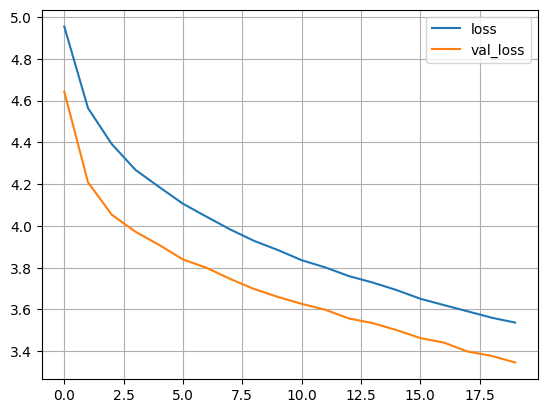

In [27]:
plt.plot(history_2.history["loss"], label="loss")
plt.plot(history_2.history["val_loss"], label="val_loss")
plt.legend()
plt.grid()

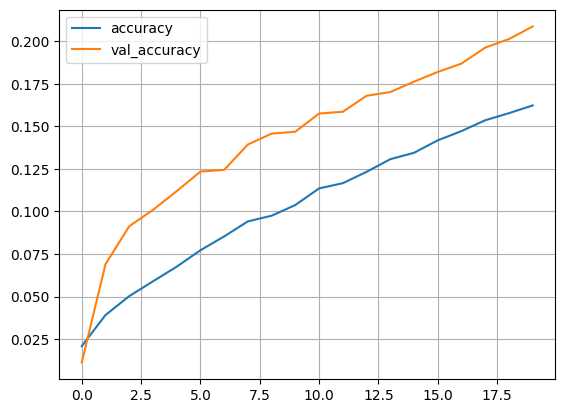

In [28]:
plt.plot(history_2.history["accuracy"], label="accuracy")
plt.plot(history_2.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.grid()

In [29]:
model_2.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 3.3219 - accuracy: 0.2117 - Top2: 0.3070


[3.3219497203826904, 0.21170000731945038, 0.3070000112056732]

### Run#3

In [30]:
model_3 = Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(128, (3, 3), activation="relu", padding="same"),
    BatchNormalization(), 
    MaxPooling2D(2, 2),
    
    # Conv2D + BatchNorm + ReLU + MaxPooling
    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    
    # Conv2D + BatchNorm + ReLU
    Conv2D(32, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.4),
    
    # Dense Layers
    Flatten(),
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    
    Dense(100, activation='softmax'),
])

model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization_13 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 64)        73792     
                                                                 
 batch_normalization_14 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                      

In [31]:
model_3.compile(optimizer=Adam(learning_rate=.0001), 
               loss=CategoricalCrossentropy(),
               metrics=['accuracy', TopKCategoricalAccuracy(k=2, name="Top2")])

In [32]:
history_3 = model_3.fit(x_train, y_train, batch_size=128, 
                     epochs=50, validation_data=(x_valid, y_valid))

Epoch 1/50
313/313 [==============================] - 6s 15ms/step - loss: 4.9641 - accuracy: 0.0210 - Top2: 0.0400 - val_loss: 4.6494 - val_accuracy: 0.0189 - val_Top2: 0.0298
Epoch 2/50
313/313 [==============================] - 4s 13ms/step - loss: 4.4964 - accuracy: 0.0448 - Top2: 0.0812 - val_loss: 4.1248 - val_accuracy: 0.0863 - val_Top2: 0.1379
Epoch 3/50
313/313 [==============================] - 4s 13ms/step - loss: 4.2738 - accuracy: 0.0611 - Top2: 0.1088 - val_loss: 3.8559 - val_accuracy: 0.1290 - val_Top2: 0.2000
Epoch 4/50
313/313 [==============================] - 4s 13ms/step - loss: 4.1046 - accuracy: 0.0783 - Top2: 0.1357 - val_loss: 3.7311 - val_accuracy: 0.1484 - val_Top2: 0.2298
Epoch 5/50
313/313 [==============================] - 4s 13ms/step - loss: 3.9738 - accuracy: 0.0948 - Top2: 0.1587 - val_loss: 3.6301 - val_accuracy: 0.1662 - val_Top2: 0.2539
Epoch 6/50
313/313 [==============================] - 4s 13ms/step - loss: 3.8655 - accuracy: 0.1078 - Top2: 0.1789

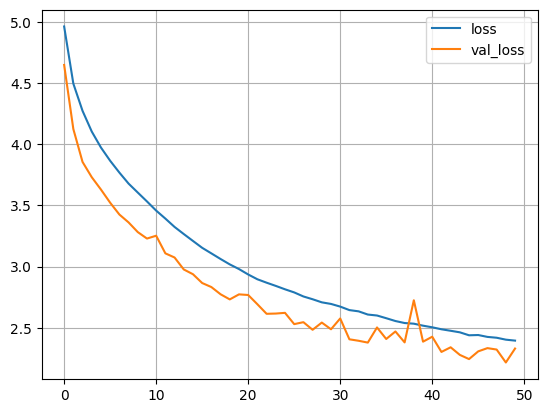

In [33]:
plt.plot(history_3.history["loss"], label="loss")
plt.plot(history_3.history["val_loss"], label="val_loss")
plt.legend()
plt.grid()

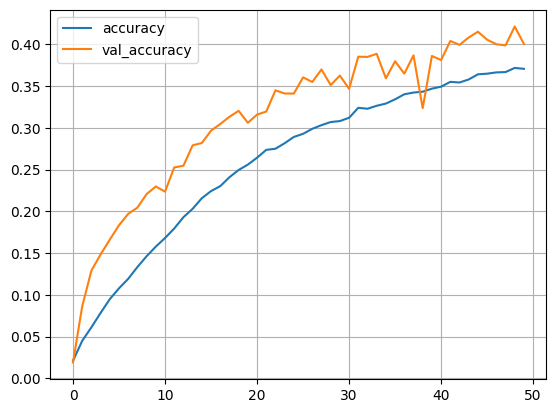

In [34]:
plt.plot(history_3.history["accuracy"], label="accuracy")
plt.plot(history_3.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.grid()

In [35]:
model_3.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 2.3017 - accuracy: 0.4069 - Top2: 0.5380


[2.3016672134399414, 0.40689998865127563, 0.5379999876022339]

### Run#4

In [36]:
model_4 = Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation="relu", padding="same"),
    BatchNormalization(), 
    # MaxPooling2D(2, 2),
    
    # Conv2D + BatchNorm + ReLU + MaxPooling
    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    # MaxPooling2D((2,2)),
    # Dropout(0.3),
    
    # Conv2D + BatchNorm + ReLU
    Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    # MaxPooling2D((2,2)),
    # Dropout(0.4),
    
    # Dense Layers
    Flatten(),
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    
    Dense(100, activation='softmax'),
])


model_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_17 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_18 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 activation_14 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 128)      

In [37]:
model_4.compile(optimizer=Adam(learning_rate=.0001), 
               loss=CategoricalCrossentropy(),
               metrics=['accuracy', TopKCategoricalAccuracy(k=2, name="Top2")])

In [38]:
history_4 = model_4.fit(x_train, y_train, batch_size=256, 
                     epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20
157/157 [==============================] - 10s 56ms/step - loss: 3.9025 - accuracy: 0.1416 - Top2: 0.2129 - val_loss: 4.9510 - val_accuracy: 0.0097 - val_Top2: 0.0229
Epoch 2/20
157/157 [==============================] - 8s 54ms/step - loss: 2.7892 - accuracy: 0.3383 - Top2: 0.4532 - val_loss: 4.9711 - val_accuracy: 0.0321 - val_Top2: 0.0495
Epoch 3/20
157/157 [==============================] - 9s 58ms/step - loss: 1.7281 - accuracy: 0.6123 - Top2: 0.7325 - val_loss: 4.0249 - val_accuracy: 0.1151 - val_Top2: 0.1772
Epoch 4/20
157/157 [==============================] - 8s 53ms/step - loss: 0.9110 - accuracy: 0.8497 - Top2: 0.9181 - val_loss: 3.3485 - val_accuracy: 0.2367 - val_Top2: 0.3284
Epoch 5/20
157/157 [==============================] - 8s 53ms/step - loss: 0.4413 - accuracy: 0.9552 - Top2: 0.9811 - val_loss: 3.0489 - val_accuracy: 0.2911 - val_Top2: 0.3922
Epoch 6/20
157/157 [==============================] - 9s 56ms/step - loss: 0.2285 - accuracy: 0.9861 - Top2: 0.995

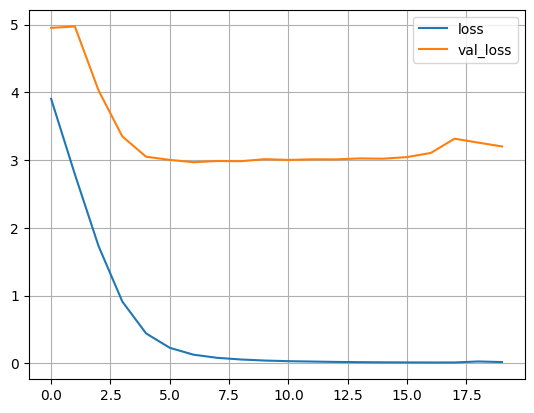

In [39]:
plt.plot(history_4.history["loss"], label="loss")
plt.plot(history_4.history["val_loss"], label="val_loss")
plt.legend()
plt.grid()

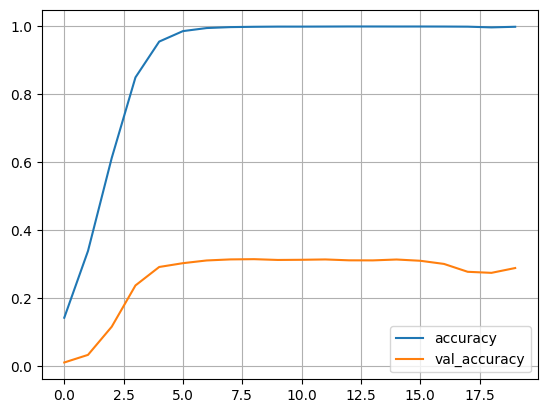

In [40]:
plt.plot(history_4.history["accuracy"], label="accuracy")
plt.plot(history_4.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.grid()

In [41]:
model_4.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 3.1744 - accuracy: 0.2887 - Top2: 0.3875


[3.1743624210357666, 0.28870001435279846, 0.38749998807907104]

## Run#5

In [12]:
model_5 = Sequential([
    # Conv2D + BatchNorm + ReLU
    Conv2D(128, (3,3), padding='same', input_shape=(32,32,3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    
    # Conv2D + BatchNorm + ReLU + MaxPooling + Dropout
    Conv2D(256, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    
    # Conv2D + BatchNorm + ReLU + MaxPooling + Dropout
    Conv2D(512, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.4),
    
    # Dense Layers
    Flatten(),
    Dense(1024),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    
    Dense(100, activation='softmax'),
])

model_5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 256)      1

In [13]:
model_5.compile(optimizer=Adam(learning_rate=.0001), 
               loss=CategoricalCrossentropy(),
               metrics=['accuracy', TopKCategoricalAccuracy(k=2, name="Top2")])

In [14]:
history_5 = model_5.fit(x_train, y_train, batch_size=256, 
                     epochs=50, validation_data=(x_valid, y_valid))

Epoch 1/50
157/157 [==============================] - 14s 57ms/step - loss: 4.4320 - accuracy: 0.0722 - Top2: 0.1203 - val_loss: 5.1710 - val_accuracy: 0.0144 - val_Top2: 0.0241
Epoch 2/50
157/157 [==============================] - 8s 54ms/step - loss: 3.8094 - accuracy: 0.1371 - Top2: 0.2133 - val_loss: 5.2436 - val_accuracy: 0.0191 - val_Top2: 0.0340
Epoch 3/50
157/157 [==============================] - 8s 54ms/step - loss: 3.5109 - accuracy: 0.1794 - Top2: 0.2706 - val_loss: 4.4114 - val_accuracy: 0.0686 - val_Top2: 0.1079
Epoch 4/50
157/157 [==============================] - 8s 54ms/step - loss: 3.2929 - accuracy: 0.2144 - Top2: 0.3184 - val_loss: 3.3595 - val_accuracy: 0.2140 - val_Top2: 0.3091
Epoch 5/50
157/157 [==============================] - 9s 55ms/step - loss: 3.0932 - accuracy: 0.2501 - Top2: 0.3618 - val_loss: 2.9670 - val_accuracy: 0.2776 - val_Top2: 0.3955
Epoch 6/50
157/157 [==============================] - 9s 54ms/step - loss: 2.9389 - accuracy: 0.2807 - Top2: 0.397

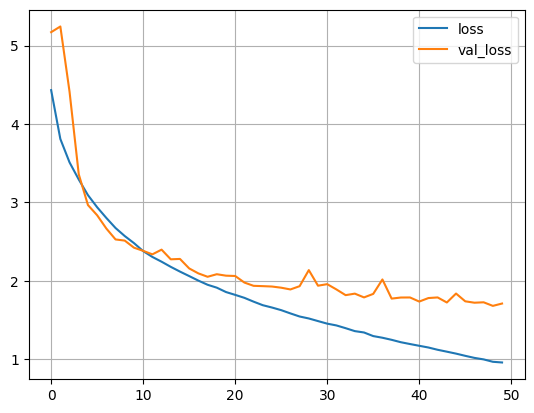

In [15]:
plt.plot(history_5.history["loss"], label="loss")
plt.plot(history_5.history["val_loss"], label="val_loss")
plt.legend()
plt.grid()

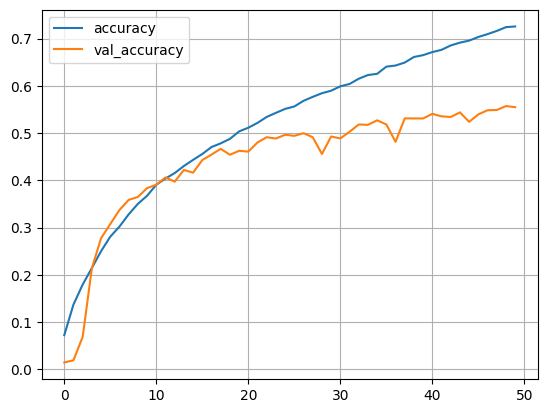

In [16]:
plt.plot(history_5.history["accuracy"], label="accuracy")
plt.plot(history_5.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.grid()

In [17]:
model_5.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.6959 - accuracy: 0.5526 - Top2: 0.6804


[1.695939302444458, 0.5526000261306763, 0.680400013923645]